# Packages

In [1]:
## import packages
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Data

In [2]:
# read in data
train = pd.read_csv('training_set.csv',encoding = 'unicode_escape', parse_dates=True)

In [3]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


AttributeError: 'AxesSubplot' object has no attribute 'show'

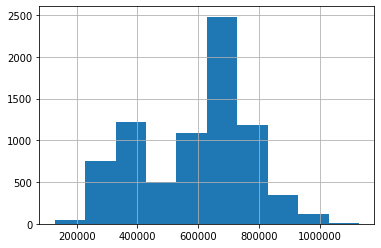

In [5]:
train['Engagements'].hist().show()

## Feature Engineering

In [6]:
# convert date to datetime
train['Created'] = pd.to_datetime(train['Created'])

c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [7]:
# create date based fields
train['weekday'] = train['Created'].apply(lambda x: x.weekday())
train['weekend'] = np.where(train['weekday'] >= 4,'Y','N')
train['hour'] = train['Created'].dt.hour
train['timeOfDay'] = np.where((train['hour'] >= 2) & (train['hour'] <=11) ,'Morning',
                              np.where((train['hour'] >= 12) & (train['hour'] <=15),'Afternoon', np.where(
                                  (train['hour'] >= 16) & (train['hour'] <=19),'Evening','Night')))
train['mon'] = train['Created'].dt.month
train['offseason'] = np.where((train['mon'] >= 7) & (train['mon'] <=9) ,'Y','N')

In [8]:
train[train.isnull().any(axis=1)]

,Engagements,Followers at Posting,Created,Type,Description,weekday,weekend,hour,timeOfDay,mon,offseason
781,728384,35727113,2019-03-31 15:12:18,Video,NaN,6,Y,15,Afternoon,3,N
808,393487,35692163,2019-03-29 04:30:09,Photo,NaN,4,Y,4,Morning,3,N
1031,755787,35393121,2019-03-15 01:03:25,Video,NaN,4,Y,1,Night,3,N
1744,763284,34300664,2019-01-29 23:34:34,Video,NaN,1,N,23,Night,1,N
4860,683799,27859939,2018-04-30 16:45:42,Video,NaN,0,N,16,Evening,4,N
5301,298599,27512159,2018-04-04 14:01:44,Photo,NaN,2,N,14,Afternoon,4,N
5920,395310,26873604,2018-02-18 20:41:29,Photo,NaN,6,Y,20,Night,2,N
6019,378886,26801941,2018-02-14 19:48:42,Photo,NaN,2,N,19,Evening,2,N
6045,737001,26776254,2018-02-12 17:23:21,Video,NaN,0,N,17,Evening,2,N
6653,768501,26158204,2018-01-01 21:01:47,Video,NaN,0,N,21,Night,1,N


In [9]:
# create lowercase caption for text based features
train.Description[train.isnull().any(axis=1)] = ''
train['DescLower'] = train['Description'].str.lower()

c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
train.isnull().sum()

Engagements             0
Followers at Posting    0
Created                 0
Type                    0
Description             0
weekday                 0
weekend                 0
hour                    0
timeOfDay               0
mon                     0
offseason               0
DescLower               0
dtype: int64

### Text Analytics

In [14]:
## TFIDF
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import math

def remove_special_char(s):

    try:
        rst = re.sub('_','',re.sub('[^\w\s]','',s))
        rst = re.sub('\s+',' ',rst)
    except:
        print(s)
        if math.isnan(float(s)):
            return ''
    return rst.strip()

def get_doc(sents):
    doc_info = []
    i = 0
    for sent in sents:
        i+=1
        cnt = count_words(sent)
        temp = {'doc_id':i,'doc_length':cnt}
        doc_info.append(temp)
    return doc_info

def count_words(sent):
    cnt = 0
    words = word_tokenize(sent)
    for word in words:
        cnt += 1
    return cnt

def create_freq_dict(sents):
    i = 0
    freqDict_list = []
    for sent in sents:
        i+=1
        freq_dict = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            if word in freq_dict:
                freq_dict[word]+=1
            else:
                freq_dict[word]=1
            tmp = {'doc_id':i, 'freq_dict':freq_dict}
        freqDict_list.append(tmp)
    return freqDict_list

def calTF(doc_info,freqDict_list):
    tf_scores = []
    for tmpdict in freqDict_list:
        myid = tmpdict['doc_id']
        for k in tmpdict['freq_dict']:
            tmp = {'doc_id':myid,
                  'TF_score': tmpdict['freq_dict'][k]/doc_info[myid-1]['doc_length'],
                  'key':k}
            tf_scores.append(tmp)
    return tf_scores

def calIDF(doc_info,freqDict_list):
    idf_scores = []
    cnt = 0
    for tmpdict in freqDict_list:
        cnt+=1
        for k in tmpdict['freq_dict'].keys():
            count = sum([k in tmpdict['freq_dict'] for tmpdict in freqDict_list])
            tmp = {'doc_id':cnt,
                  'IDF_score': math.log(len(doc_info)/count),
                  'key':k}
            idf_scores.append(tmp)
    return idf_scores

def calTFIDF (tf_scores,idf_scores):
    tfidf_Scores = []
    for j in idf_scores:
        for i in tf_scores:
            if j['key'] == i['key'] and j['doc_id'] == i['doc_id']:
                temp = {
                    'doc_id':j['doc_id'],
                    'tfidf_score': j['IDF_score']*i['TF_score'],
                    'key':i['key']
                }
                break
        tfidf_Scores.append(temp)
    return tfidf_Scores

[nltk_data] Downloading package punkt to C:\Users\JD
[nltk_data]     Cook\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [15]:
post_ls = train.DescLower.values
post_ls = [remove_special_char(s) for s in post_ls]
doc_info = get_doc(post_ls)
freqDict_list = create_freq_dict(post_ls)
tfidf_scores = calTFIDF(calTF(doc_info,freqDict_list),calIDF(doc_info,freqDict_list))


In [16]:
word_ls = [x['key'] for x in tfidf_scores]
score_ls = [x['tfidf_score'] for x in tfidf_scores]
word_set = set([x['key'] for x in tfidf_scores])

word_dict = {}
for word in word_set:
    indices = [i for i,x in enumerate(tfidf_scores) if x['key'] == word]
    scores = [score_ls[x] for x in indices]
    word_dict[word] = sum(scores)/len(scores)

word_engage = {}
for word in word_set:
    word_engage[word] = 0

for i,sent in enumerate(train.DescLower.values):
    this_words = word_tokenize(remove_special_char(sent))
    this_engage = train.Engagements.values[i]
    this_scores = []
    for word in this_words:
        if word in word_dict:
            this_scores.append(word_dict[word])
        else:
            this_scores.append(0)
    this_scores = np.array(this_scores) # tf idf values for each word
    this_scores = this_scores/sum(this_scores) # % of its tfidf values
    
    for j,word in enumerate(this_words):
        if word in word_engage:
            word_engage[word] += this_engage*this_scores[j]

#### Word Engagment Shares

In [57]:

import operator
sorted_engage = sorted(word_engage.items(), key=operator.itemgetter(1), reverse = True)
sorted_engage

[('the', 61405203.52366523),
 ('for', 45341849.53704449),
 ('to', 39529813.78681452),
 ('in', 37728429.44991266),
 ('kingjames', 37382212.91725452),
 ('it', 34449052.74745733),
 ('with', 28854737.734769642),
 ('up', 27278453.305204228),
 ('on', 25173868.21858193),
 ('thisiswhyweplay', 24581250.009123094),
 ('of', 22656988.64735945),
 ('slam', 21870911.41364487),
 ('from', 20701102.05137535),
 ('nbaontnt', 19937731.026949573),
 ('nbapreseason', 19554866.220570587),
 ('nbaonabc', 19369848.820956256),
 ('nbaplayoffs', 19041929.77980225),
 ('stephencurry30', 18892793.52458515),
 ('a', 18841907.512596976),
 ('jharden13', 18836048.658198666),
 ('transition', 18711505.00964727),
 ('giannisan34', 18543649.860812314),
 ('action', 18517924.672773782),
 ('kyrieirving', 17771312.072909843),
 ('off', 17591915.7657081),
 ('x', 17522079.227170628),
 ('his', 17114334.039742626),
 ('back', 17102039.411699913),
 ('espn', 16880432.09214757),
 ('nbaallstar', 16429446.859087087),
 ('phantomcam', 16398255.8

In [58]:
## create caption based fields
train['CapLength'] = train['Description'].str.len().fillna(0) # length of caption
# list of most popular players based on jersey sales from 2018 and 2019, including instagram specific names
popPlayerRegex = 'lebron|kingjames|curry|stephencurry|giannis|kyrie|embiid|harden|westbrook|russwest44|durant|easymoneysniper|porzingis|kporzee|simmons|bensimmons|dwyane|kawhi|spidadmitchell|dwyanewade|cp3'
train['popPlayer'] = train['DescLower'].str.contains(popPlayerRegex,regex=True)*1
# list of most popular teams based on juersey sales from 2018 and 2019
popTeamRegex = 'lakers|warriors|celtics|knicks|sixers|bucks|thunder|rockets|raptors|cavs|bulls'
top10Team = 'warriors|cavs|lakers|chicagobulls|okcthunder|miamiheat|celtics|houstonrockets|spurs|laclippers'
top5Team = 'warriors|cavs|lakers|chicagobulls|okcthunder'
top5to10Team = 'miamiheat|celtics|houstonrockets|spurs|laclippers'
top10to15Team = 'nyknicks|raptors|pacers|sixers|timberwolves'
top15to20Team = 'bucks|trailblazers|pelicansnba|washwizards|hornets'
top20to25Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings'
top25to30Team = 'detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
top20Team = 'nyknicks|raptors|pacers|sixers|timberwolves|bucks|trailblazers|pelicansnba|washwizards|hornets'
top30Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings|detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
train['popTeam'] = train['DescLower'].str.contains(popTeamRegex,regex=True)*1
train['top10Team'] = train['DescLower'].str.contains(top10Team,regex=True)*1
train['top20Team'] = train['DescLower'].str.contains(top20Team,regex=True)*1
train['top30Team'] = train['DescLower'].str.contains(top30Team,regex=True)*1
train['top5Team'] = train['DescLower'].str.contains(top5Team,regex=True)*1
train['top5to10Team'] = train['DescLower'].str.contains(top5to10Team,regex=True)*1
train['top10to15Team'] = train['DescLower'].str.contains(top10to15Team,regex=True)*1
train['top15to20Team'] = train['DescLower'].str.contains(top15to20Team,regex=True)*1
train['top20to25Team'] = train['DescLower'].str.contains(top20to25Team,regex=True)*1
train['top25to30Team'] = train['DescLower'].str.contains(top25to30Team,regex=True)*1
# post is tagged at another insta handle
train['at'] = train['DescLower'].str.contains('@',regex=True)*1
# post contains a hashtag
train['hash'] = train['DescLower'].str.contains('#',regex=True)*1
# tries to capture games on national tv
natlTvRegex = 'tnt|espn|abc|nbatv'
train['natlTV'] = train['DescLower'].str.contains(natlTvRegex,regex=True)*1
# posts about an even such as allstar game or playoffs or draft
train['event'] = train['DescLower'].str.contains('allstar|all-star|finals|playoff|draft|slamdunk|thisiswhyweplay|phantomcam|kiatipoff|nbaontnt|nbapreseason|nbaonabc|nbaplayoffs|nbafinals',regex=True)*1

# Features

In [59]:
# variables used in model, inclduing response variable
train_features = train[['Engagements','Type','weekend','mon','timeOfDay','CapLength','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']]

In [39]:
train_features.head()

,Engagements,Type,weekend,mon,timeOfDay,CapLength,popPlayer,top5Team,top5to10Team,top10to15Team,top15to20Team,top20to25Team,top25to30Team,at,hash,natlTV,event
0,502093,Video,N,5,Night,95,0,0,0,1,0,0,0,1,0,0,0
1,603380,Video,N,5,Night,64,0,0,0,1,0,0,0,1,0,1,0
2,603380,Video,N,5,Night,46,0,0,0,0,1,0,0,1,0,0,0
3,725100,Video,N,5,Night,43,1,0,0,0,0,0,0,0,0,1,0
4,661446,Video,N,5,Night,57,1,0,0,0,0,0,0,1,0,1,0


In [40]:
train.describe()

,Engagements,Followers at Posting,weekday,hour,mon,CapLength,popPlayer,popTeam,top10Team,top20Team,...,top5Team,top5to10Team,top10to15Team,top15to20Team,top20to25Team,top25to30Team,at,hash,natlTV,event
count,7.766000e+03,7.766000e+03,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,...,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000
mean,5.923129e+05,3.042770e+07,3.081767,15.925444,5.996652,69.177440,0.283029,0.280711,0.235900,0.158898,...,0.145120,0.114345,0.090394,0.078419,0.043266,0.050605,0.803631,0.480556,0.187870,0.238990
std,1.792682e+05,3.748957e+06,1.970062,7.319283,3.910491,37.306999,0.450499,0.449375,0.424587,0.365604,...,0.352244,0.318250,0.286764,0.268847,0.203467,0.219204,0.397276,0.499654,0.390634,0.426494
min,1.278160e+05,2.487554e+07,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.173900e+05,2.698910e+07,1.000000,12.000000,3.000000,44.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,6.397285e+05,3.004747e+07,3.000000,19.000000,5.000000,63.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,7.216282e+05,3.392854e+07,5.000000,21.000000,10.000000,89.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.129585e+06,3.698468e+07,6.000000,23.000000,12.000000,639.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


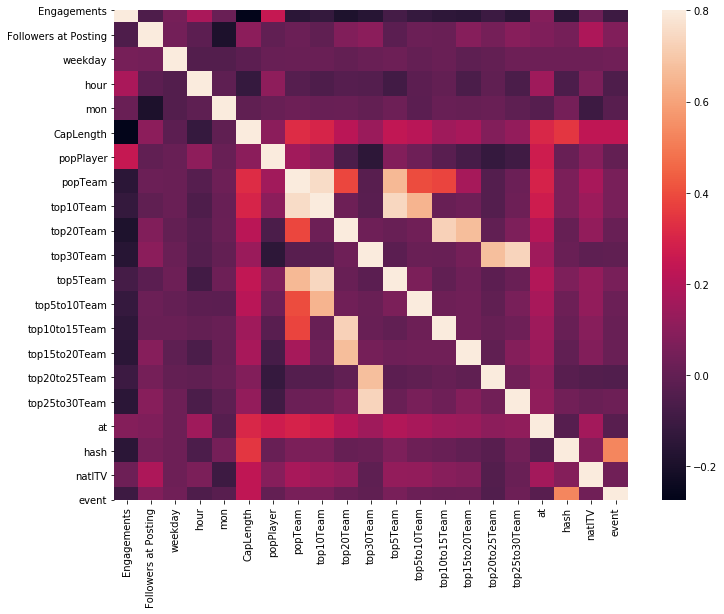

In [42]:
import seaborn as sns
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

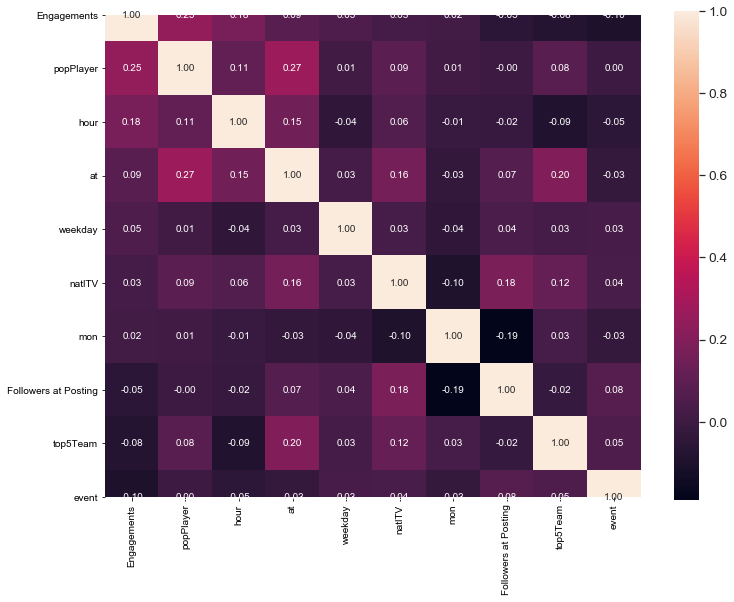

In [43]:
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Engagements')['Engagements'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [60]:
# one hot encode categorical variables and create dataframe used in modeling

# categorical columns
cat_columns = ['Type','weekend','timeOfDay','mon','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']
train_features_model = pd.get_dummies(data=train_features, columns=cat_columns)

train_features_model.head()

,Engagements,CapLength,Type_Album,Type_Photo,Type_Video,weekend_N,weekend_Y,timeOfDay_Afternoon,timeOfDay_Evening,timeOfDay_Morning,...,top25to30Team_0,top25to30Team_1,at_0,at_1,hash_0,hash_1,natlTV_0,natlTV_1,event_0,event_1
0,502093,95,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
1,603380,64,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,1,1,0
2,603380,46,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
3,725100,43,0,0,1,1,0,0,0,0,...,1,0,1,0,1,0,0,1,1,0
4,661446,57,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,1,1,0


In [61]:
train_features_model['Followers at Posting'] = train['Followers at Posting']

In [62]:
## create features and response data frames
features = train_features_model[train_features_model.columns.tolist()[1:]]
response = train_features_model['Engagements']

## XGBoost


In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=132)

#### random model

In [49]:
import xgboost


model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=132) 

In [50]:
model.fit(X_train,y_train)

c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=132,
             silent=None, subsample=0.6, verbosity=1)

##### training MAPE and R^2

In [64]:
pred = model.predict(X_train)
# calculate MAPE
np.mean(np.abs((y_train - pred) / y_train)) * 100

6.583677555522054

In [65]:
#calculate R2
r2_score(y_train, pred)

0.9122702206188145

##### testing MAPE and R^2

In [66]:
pred = model.predict(X_test)
# calculate MAPE
np.mean(np.abs((y_test - pred) / y_test)) * 100

7.599067999767607

In [67]:
#calculate R2
r2_score(y_test, pred) # overfitted 

0.880911017307359

In [68]:
sorted(model.get_booster().get_score(importance_type='gain').items(),key = lambda x: x[1],reverse = True)

[('Type_Video', 1988105691815.7625),
 ('Type_Photo', 592890163325.2625),
 ('Type_Album', 287911148543.8298),
 ('mon_7', 177060269989.6842),
 ('at_1', 163861443994.78262),
 ('top10to15Team_0', 85975138077.62712),
 ('at_0', 78407067777.18446),
 ('top15to20Team_0', 69709437251.5),
 ('popPlayer_1', 64985699551.92118),
 ('top10to15Team_1', 63562442098.181816),
 ('timeOfDay_Night', 54688229460.14706),
 ('top20to25Team_0', 51398161662.77551),
 ('top25to30Team_1', 48285642213.78378),
 ('popPlayer_0', 46095573858.65681),
 ('natlTV_1', 37248600131.521736),
 ('mon_8', 36656410346.404495),
 ('CapLength', 32907143128.96625),
 ('mon_9', 32135122830.38298),
 ('mon_12', 31662097967.494507),
 ('weekend_N', 31328586700.76259),
 ('mon_2', 30359671432.967033),
 ('mon_5', 28951256749.1),
 ('mon_4', 28624810251.48387),
 ('mon_10', 27122006353.914288),
 ('top15to20Team_1', 26803810278.18182),
 ('top5to10Team_0', 26028945808.032787),
 ('weekend_Y', 22265024296.83544),
 ('natlTV_0', 22009380713.741497),
 ('top

### Tuning

In [69]:
#for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[100,300,500,700,1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=132)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing,cv =10,
                        n_jobs=4,iid=False, verbose=100,scoring='neg_mean_squared_error')
gsearch1.fit(X_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)



Fitting 10 folds for each of 12960 candidates, totalling 129600 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   19.3s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   19.4s

Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   19.4s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:   32.2s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  45 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:   42.3s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:   55.4s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:   57.9s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:  1.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:  1.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:  1.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  95 tasks      | elapsed:  1.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:  1.5min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=i

Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 124 tasks      | elapsed:  1.7min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 125 tasks      | elapsed:  1.7min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 

[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:  1.9min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:  1.9min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:  2.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 157 tasks      | elapsed:  2.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:  2.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).[Parallel(n_jobs=4)]: Done 174 tasks      | elapsed:  2.3min

Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:  2.5min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=i

[Parallel(n_jobs=4)]: Done 204 tasks      | elapsed:  3.0min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 205 tasks      | elapsed:  3.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

KeyboardInterrupt: 

### Best Model

In [70]:

best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
                 gamma=1,                 
                 learning_rate=0.03,
                 max_depth=5,
                 min_child_weight=2,
                 n_estimators=700,                                                                    
                 reg_alpha=0.5,
                 reg_lambda=0.5,
                 subsample=0.8,
                 seed=132)
best_xgb_model.fit(X_train,y_train)

c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=700,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=1, seed=132,
             silent=None, subsample=0.8, verbosity=1)

In [71]:
pred = best_xgb_model.predict(X_train)
# calculate MAPE
print('MAPE: %s'%(np.mean(np.abs((y_train - pred) / y_train)) * 100))
#calculate R2
print('train r2: %s'%(r2_score(y_train, pred)))

pred = best_xgb_model.predict(X_test)
# calculate MAPE
print('test MAPE: %s'%(np.mean(np.abs((y_test - pred) / y_test)) * 100))
#calculate R2
print('test r2: %s'%(r2_score(y_test, pred)))

MAPE: 5.741208761778649
train r2: 0.9289159886423023
test MAPE: 7.356207162694611
test r2: 0.8853242960769419


In [72]:
sorted(best_xgb_model.get_booster().get_score(importance_type='gain').items(),key = lambda x: x[1],reverse = True)

[('Type_Video', 2691540346513.796),
 ('Type_Photo', 686470371882.639),
 ('Type_Album', 610814688733.8024),
 ('mon_7', 264363540428.95557),
 ('top10to15Team_1', 107120217068.66667),
 ('at_0', 100091062260.5041),
 ('at_1', 88715286643.43158),
 ('top15to20Team_1', 77128376353.23636),
 ('top10to15Team_0', 70292162936.875),
 ('popPlayer_1', 61564060740.96342),
 ('popPlayer_0', 52386823567.91029),
 ('mon_9', 51673640851.05556),
 ('natlTV_1', 51355592401.149605),
 ('top15to20Team_0', 48061697818.55556),
 ('timeOfDay_Night', 47682727548.322),
 ('mon_2', 42388627417.89423),
 ('mon_10', 42149871670.92086),
 ('top25to30Team_1', 40531332561.73077),
 ('mon_12', 39859544980.56044),
 ('top20to25Team_1', 39823791766.70588),
 ('mon_8', 38650937949.564354),
 ('mon_5', 38569682498.82727),
 ('top25to30Team_0', 36232580255.76159),
 ('top20to25Team_0', 35200490602.59091),
 ('natlTV_0', 29117344934.92704),
 ('mon_4', 25310572442.022987),
 ('weekend_N', 24980607551.21875),
 ('weekend_Y', 24855678136.589474),


# HOLDOUT SET

#### Build Features

In [153]:
holdout = pd.read_csv('holdout_set.csv',encoding = 'unicode_escape', parse_dates=True)
holdout_original = holdout
holdout.head()

,Engagements,Followers at Posting,Created,Type,Description
0,NaN,36984682,2019-05-22 00:31:55 EDT,Photo,The @raptors even up the Eastern Conference Fi...
1,NaN,36984682,2019-05-21 23:20:41 EDT,Photo,The @raptors even the Eastern Conference Final...
2,NaN,36984682,2019-05-21 21:18:51 EDT,Video,@sergeibaka keeps it alive for the @raptors! (...
3,NaN,36955156,2019-05-21 18:20:09 EDT,Video,???? The SUPERHUMAN HANDS of Giannis & Kawhi ?...
4,NaN,36955156,2019-05-21 15:04:31 EDT,Video,?? the @raptors & @bucks in transition! #NBABr...


In [136]:
# convert date to datetime
holdout['Created'] = pd.to_datetime(holdout['Created'])

In [137]:
# create date based fields
holdout['weekday'] = holdout['Created'].apply(lambda x: x.weekday())
holdout['weekend'] = np.where(holdout['weekday'] >= 4,'Y','N')
holdout['hour'] = holdout['Created'].dt.hour
holdout['timeOfDay'] = np.where((holdout['hour'] >= 2) & (holdout['hour'] <=11) ,'Morning',
                              np.where((holdout['hour'] >= 12) & (holdout['hour'] <=15),'Afternoon', np.where(
                                  (holdout['hour'] >= 16) & (holdout['hour'] <=19),'Evening','Night')))
holdout['mon'] = holdout['Created'].dt.month
holdout['offseason'] = np.where((holdout['mon'] >= 7) & (holdout['mon'] <=9) ,'Y','N')

In [138]:
holdout[holdout.isnull().any(axis=1)]

,Engagements,Followers at Posting,Created,Type,Description,weekday,weekend,hour,timeOfDay,mon,offseason
0,NaN,36984682,2019-05-22 00:31:55,Photo,The @raptors even up the Eastern Conference Fi...,2,N,0,Night,5,N
1,NaN,36984682,2019-05-21 23:20:41,Photo,The @raptors even the Eastern Conference Final...,1,N,23,Night,5,N
2,NaN,36984682,2019-05-21 21:18:51,Video,@sergeibaka keeps it alive for the @raptors! (...,1,N,21,Night,5,N
3,NaN,36955156,2019-05-21 18:20:09,Video,???? The SUPERHUMAN HANDS of Giannis & Kawhi ?...,1,N,18,Evening,5,N
4,NaN,36955156,2019-05-21 15:04:31,Video,?? the @raptors & @bucks in transition! #NBABr...,1,N,15,Afternoon,5,N
5,NaN,36955156,2019-05-21 02:09:47,Photo,The @warriors advance to the 2019 #NBAFinals p...,1,N,2,Morning,5,N
6,NaN,36955156,2019-05-21 01:30:13,Video,Big bro wins this one! #PhantomCam,1,N,1,Night,5,N
7,NaN,36955156,2019-05-20 22:25:20,Video,@stephencurry30 pulls up from deep to end the ...,0,N,22,Night,5,N
8,NaN,36955156,2019-05-20 22:09:36,Video,The @warriors move the ball to find Andrew Bog...,0,N,22,Night,5,N
9,NaN,36928789,2019-05-20 15:26:07,Video,?? @money23green micd up in Game 3 of the WCF...,0,N,15,Afternoon,5,N


In [139]:
# create lowercase caption for text based features
holdout['DescLower'] = holdout['Description'].str.lower()

In [140]:
## create caption based fields
holdout['CapLength'] = holdout['Description'].str.len().fillna(0) # length of caption
# list of most popular players based on jersey sales from 2018 and 2019, including instagram specific names
popPlayerRegex = 'lebron|kingjames|curry|stephencurry|giannis|kyrie|embiid|harden|westbrook|russwest44|durant|easymoneysniper|porzingis|kporzee|simmons|bensimmons|dwyane|kawhi|spidadmitchell|dwyanewade|cp3'
holdout['popPlayer'] = holdout['DescLower'].str.contains(popPlayerRegex,regex=True)*1
# list of most popular teams based on juersey sales from 2018 and 2019
popTeamRegex = 'lakers|warriors|celtics|knicks|sixers|bucks|thunder|rockets|raptors|cavs|bulls'
top10Team = 'warriors|cavs|lakers|chicagobulls|okcthunder|miamiheat|celtics|houstonrockets|spurs|laclippers'
top5Team = 'warriors|cavs|lakers|chicagobulls|okcthunder'
top5to10Team = 'miamiheat|celtics|houstonrockets|spurs|laclippers'
top10to15Team = 'nyknicks|raptors|pacers|sixers|timberwolves'
top15to20Team = 'bucks|trailblazers|pelicansnba|washwizards|hornets'
top20to25Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings'
top25to30Team = 'detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
top20Team = 'nyknicks|raptors|pacers|sixers|timberwolves|bucks|trailblazers|pelicansnba|washwizards|hornets'
top30Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings|detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
holdout['popTeam'] = holdout['DescLower'].str.contains(popTeamRegex,regex=True)*1
holdout['top10Team'] = holdout['DescLower'].str.contains(top10Team,regex=True)*1
holdout['top20Team'] = holdout['DescLower'].str.contains(top20Team,regex=True)*1
holdout['top30Team'] = holdout['DescLower'].str.contains(top30Team,regex=True)*1
holdout['top5Team'] = holdout['DescLower'].str.contains(top5Team,regex=True)*1
holdout['top5to10Team'] = holdout['DescLower'].str.contains(top5to10Team,regex=True)*1
holdout['top10to15Team'] = holdout['DescLower'].str.contains(top10to15Team,regex=True)*1
holdout['top15to20Team'] = holdout['DescLower'].str.contains(top15to20Team,regex=True)*1
holdout['top20to25Team'] = holdout['DescLower'].str.contains(top20to25Team,regex=True)*1
holdout['top25to30Team'] = holdout['DescLower'].str.contains(top25to30Team,regex=True)*1
# post is tagged at another insta handle
holdout['at'] = holdout['DescLower'].str.contains('@',regex=True)*1
# post contains a hashtag
holdout['hash'] = holdout['DescLower'].str.contains('#',regex=True)*1
# tries to capture games on national tv
natlTvRegex = 'tnt|espn|abc|nbatv'
holdout['natlTV'] = holdout['DescLower'].str.contains(natlTvRegex,regex=True)*1
# posts about an even such as allstar game or playoffs or draft
holdout['event'] = holdout['DescLower'].str.contains('allstar|all-star|finals|playoff|draft|slamdunk|thisiswhyweplay|phantomcam|kiatipoff|nbaontnt|nbapreseason|nbaonabc|nbaplayoffs|nbafinals',regex=True)*1

In [141]:
holdout[['Type','weekend','mon','timeOfDay','CapLength','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']]

,Type,weekend,mon,timeOfDay,CapLength,popPlayer,top5Team,top5to10Team,top10to15Team,top15to20Team,top20to25Team,top25to30Team,at,hash,natlTV,event
0,Photo,N,5,Night,55,0,0,0,1,0,0,0,1,0,0,1
1,Photo,N,5,Night,92,0,0,0,1,1,0,0,1,0,0,1
2,Video,N,5,Night,60,0,0,0,1,0,0,0,1,0,1,1
3,Video,N,5,Evening,108,1,0,0,1,1,0,0,1,0,1,1
4,Video,N,5,Afternoon,124,0,0,0,1,1,0,0,1,1,1,1
5,Photo,N,5,Morning,70,0,1,0,0,0,0,0,1,1,0,1
6,Video,N,5,Night,34,0,0,0,0,0,0,0,0,1,0,1
7,Video,N,5,Night,59,1,0,0,0,0,0,0,1,0,1,0
8,Video,N,5,Night,80,0,1,0,0,0,0,0,1,0,1,0
9,Video,N,5,Afternoon,122,0,1,0,0,1,0,0,1,0,1,0


In [142]:
# variables used in model, inclduing response variable
holdout_features = holdout[['Engagements','Type','weekend','mon','timeOfDay','CapLength','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']]

In [143]:
# one hot encode categorical variables and create dataframe used in modeling

# categorical columns
cat_columns = ['Type','weekend','timeOfDay','mon','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']
holdout_features_model = pd.get_dummies(data=holdout_features, columns=cat_columns)

holdout_features_model.head()

,Engagements,CapLength,Type_Album,Type_Photo,Type_Video,weekend_N,weekend_Y,timeOfDay_Afternoon,timeOfDay_Evening,timeOfDay_Morning,...,top25to30Team_0,top25to30Team_1,at_0,at_1,hash_0,hash_1,natlTV_0,natlTV_1,event_0,event_1
0,NaN,55,0,1,0,1,0,0,0,0,...,1,0,0,1,1,0,1,0,0,1
1,NaN,92,0,1,0,1,0,0,0,0,...,1,0,0,1,1,0,1,0,0,1
2,NaN,60,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,1,0,1
3,NaN,108,0,0,1,1,0,0,1,0,...,1,0,0,1,1,0,0,1,0,1
4,NaN,124,0,0,1,1,0,1,0,0,...,1,0,0,1,0,1,0,1,0,1


In [144]:
holdout_features_model['Followers at Posting'] = holdout['Followers at Posting']

In [145]:
## create features and response data frames
features_h = holdout_features_model[holdout_features_model.columns.tolist()[1:]]

In [146]:
features_h.head()

,CapLength,Type_Album,Type_Photo,Type_Video,weekend_N,weekend_Y,timeOfDay_Afternoon,timeOfDay_Evening,timeOfDay_Morning,timeOfDay_Night,...,top25to30Team_1,at_0,at_1,hash_0,hash_1,natlTV_0,natlTV_1,event_0,event_1,Followers at Posting
0,55,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,1,0,0,1,36984682
1,92,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,1,0,0,1,36984682
2,60,0,0,1,1,0,0,0,0,1,...,0,0,1,1,0,0,1,0,1,36984682
3,108,0,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,36955156
4,124,0,0,1,1,0,1,0,0,0,...,0,0,1,0,1,0,1,0,1,36955156


#### Predict Holdout Set

In [147]:
predictions = best_xgb_model.predict(features_h)

In [154]:
holdout_original["Engagements"] = predictions

In [155]:
holdout_original

,Engagements,Followers at Posting,Created,Type,Description
0,352733.53125,36984682,2019-05-22 00:31:55 EDT,Photo,The @raptors even up the Eastern Conference Fi...
1,335401.81250,36984682,2019-05-21 23:20:41 EDT,Photo,The @raptors even the Eastern Conference Final...
2,582136.00000,36984682,2019-05-21 21:18:51 EDT,Video,@sergeibaka keeps it alive for the @raptors! (...
3,521760.81250,36955156,2019-05-21 18:20:09 EDT,Video,???? The SUPERHUMAN HANDS of Giannis & Kawhi ?...
4,539584.50000,36955156,2019-05-21 15:04:31 EDT,Video,?? the @raptors & @bucks in transition! #NBABr...
5,451089.59375,36955156,2019-05-21 02:09:47 EDT,Photo,The @warriors advance to the 2019 #NBAFinals p...
6,713142.75000,36955156,2019-05-21 01:30:13 EDT,Video,Big bro wins this one! #PhantomCam
7,695580.75000,36955156,2019-05-20 22:25:20 EDT,Video,@stephencurry30 pulls up from deep to end the ...
8,662058.12500,36955156,2019-05-20 22:09:36 EDT,Video,The @warriors move the ball to find Andrew Bog...
9,586450.43750,36928789,2019-05-20 15:26:07 EDT,Video,?? @money23green micd up in Game 3 of the WCF...


In [156]:
holdout_original.to_csv("final_set.csv")